### 0. Import libraries

In [465]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/adult-census-income/adult.csv


In [466]:
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (9, 9)
warnings.filterwarnings("ignore")

### 1. Load data

In [467]:
df = pd.read_csv("/kaggle/input/adult-census-income/adult.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [468]:
df.shape

(32561, 15)

In [469]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

### 2. Data wrangling

#### 2.1) Missing Values

In our data, we can observe missing values encoded with the sign **"?"**. Replace them with **np.nan**

In [470]:
df.replace({"?": np.nan}, inplace = True)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Let's count the number of missing values:

In [471]:
df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

Find the percentage ratio:

In [472]:
df_isna = df.isna().sum() * 100 / len(df)
df_isna = df_isna.round(2)
df_isna

age               0.00
workclass         5.64
fnlwgt            0.00
education         0.00
education.num     0.00
marital.status    0.00
occupation        5.66
relationship      0.00
race              0.00
sex               0.00
capital.gain      0.00
capital.loss      0.00
hours.per.week    0.00
native.country    1.79
income            0.00
dtype: float64

Let's create a **heat map of the missing values** for clarity:

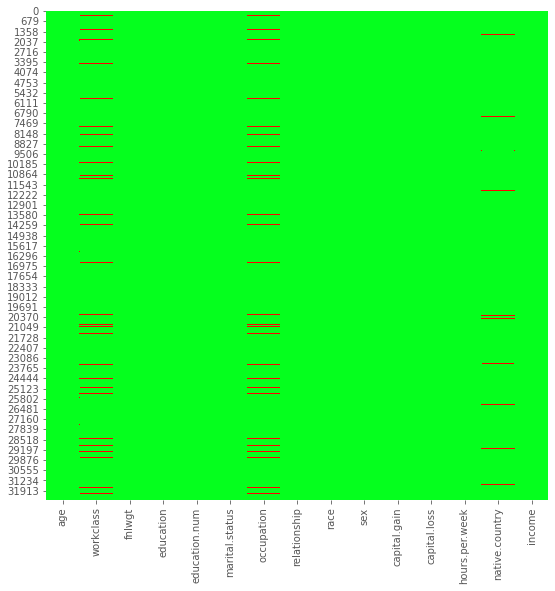

In [473]:
colors = ["#05ff1e", '#ff0000']
sns.heatmap(df.isna(), cbar = False, cmap = colors);

Let's look at the type of columns with missing values:

In [474]:
df[["workclass", "occupation", "native.country"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       30725 non-null  object
 1   occupation      30718 non-null  object
 2   native.country  31978 non-null  object
dtypes: object(3)
memory usage: 763.3+ KB


Replace the missing categorical values most frequent value:

In [475]:
def impute_nan(dataframe, column_name):
    frequent_value = dataframe[column_name].mode()[0]
    dataframe[column_name] = dataframe[column_name].fillna(frequent_value)

In [476]:
for column in ["workclass", "occupation", "native.country"]:
    impute_nan(df, column)

In [477]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

#### 2.2) Outliers

Let's see if there are **outliers** in our data:

In [478]:
df_float = df.select_dtypes(include = [np.number])
df_float.columns

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object')

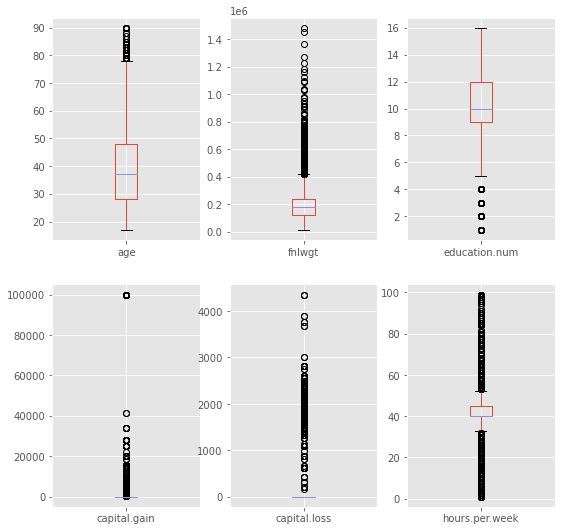

In [479]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (9, 9))

df.boxplot(column = "age", ax = axes[0, 0]);
df.boxplot(column = "fnlwgt", ax = axes[0, 1]);
df.boxplot(column = "education.num", ax = axes[0, 2]);
df.boxplot(column = "capital.gain", ax = axes[1, 0]);
df.boxplot(column = "capital.loss", ax = axes[1, 1]);
df.boxplot(column = "hours.per.week", ax = axes[1, 2]);

Remove values that deviate by 3 standard deviations:

In [480]:
z_score = np.abs(stats.zscore(df_float))
df = df[(z_score < 3).all(axis = 1)]

In [481]:
df.reset_index(inplace = True)
df.drop("index", axis = 1, inplace = True)

#### 2.3) Working with columns and values

In [482]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,62,Local-gov,159908,Bachelors,13,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,1258,38,United-States,<=50K
1,72,Local-gov,144515,Doctorate,16,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1258,40,United-States,<=50K
2,76,Private,224680,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1258,20,United-States,<=50K
3,66,Private,350498,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,1258,20,United-States,<=50K
4,33,Local-gov,262042,HS-grad,9,Divorced,Adm-clerical,Own-child,White,Female,0,1138,40,United-States,<=50K


Edit the columns:

In [483]:
df.columns = ["age", "workclass", "final_weight", "education", "education_num", "martial_status",
             "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
             "hours_per_week", "native_country", "income"]

We will reduce all columns with strings to lowercase:

In [484]:
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = df[column].str.lower()
        
df.head()

,age,workclass,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,62,local-gov,159908,bachelors,13,married-civ-spouse,adm-clerical,wife,white,female,0,1258,38,united-states,<=50k
1,72,local-gov,144515,doctorate,16,married-civ-spouse,exec-managerial,husband,white,male,0,1258,40,united-states,<=50k
2,76,private,224680,prof-school,15,married-civ-spouse,prof-specialty,husband,white,male,0,1258,20,united-states,<=50k
3,66,private,350498,some-college,10,married-civ-spouse,transport-moving,husband,white,male,0,1258,20,united-states,<=50k
4,33,local-gov,262042,hs-grad,9,divorced,adm-clerical,own-child,white,female,0,1138,40,united-states,<=50k


### 3. Exploratory data analysis (EDA)

Columns:

1. **age** - the age of an individual
2. **workclass** - a general term to represent the employment status of an individual
3. **final weight** -  in other words, this is the number of people the census believes the entry represents
4. **education** - the highest level of education achieved by an individual
5. **education_num** - the highest level of education achieved in numerical form.
6. **marital_status** - marital status of an individual. Married civ spouse corresponds to a civilian spouse while Married AF spouse is a spouse in the Armed Forces
7. **occupation** - the general type of occupation of an individual
8. **relationship** - represents what this individual is relative to others
9. **race** - descriptions of an individual’s race
10. **sex** - the biological sex of the individual
11. **capital_gain** - capital gains for an individual
12. **capital_loss** - capital loss for an individual
13. **hours_per_week**  -  the hours an individual has reported to work per week continuous
14. **income** - whether or not an individual makes more than 50,000 dollars annually (the label)

P.S. The description of the columns was taken from this file: <a href = "http://cseweb.ucsd.edu/classes/sp15/cse190-c/reports/sp15/048.pdf">click</a>

#### 3.1) Descriptive statistics

In [485]:
df.describe()

,age,final_weight,education_num,capital_gain,capital_loss,hours_per_week
count,29828.000000,29828.000000,29828.000000,29828.000000,29828.000000,29828.000000
mean,38.143758,185192.521590,10.077980,570.217212,1.209367,39.896104
std,13.357445,94546.882879,2.452859,2332.536197,32.711554,11.139495
min,17.000000,12285.000000,3.000000,0.000000,0.000000,4.000000
25%,27.000000,117508.500000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,177667.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,234279.250000,12.000000,0.000000,0.000000,45.000000
max,79.000000,506329.000000,16.000000,22040.000000,1258.000000,77.000000


In [486]:
df.select_dtypes(exclude = [np.number]).columns

Index(['workclass', 'education', 'martial_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'income'],
      dtype='object')

Value_counts for **workclass**:

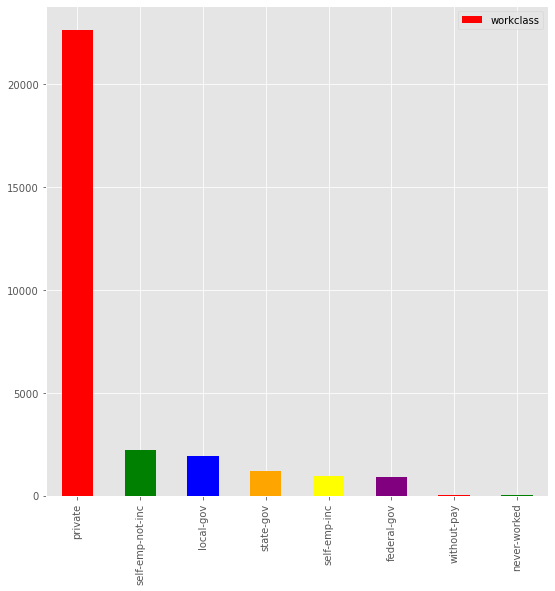

In [487]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["workclass"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **education**:

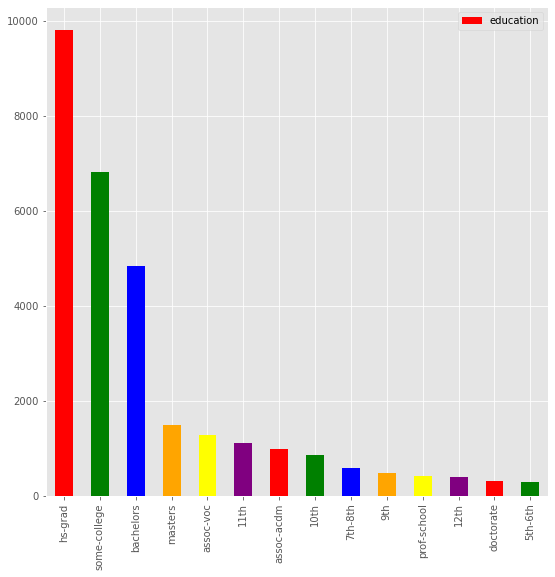

In [488]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["education"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **martial_status**:

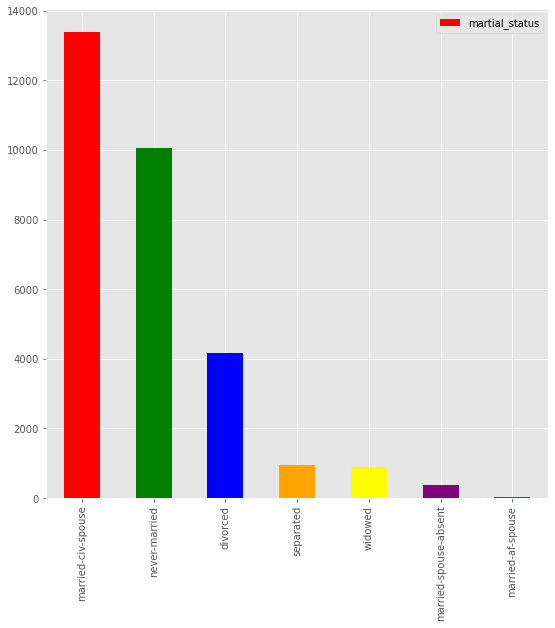

In [489]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["martial_status"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **occupations**:

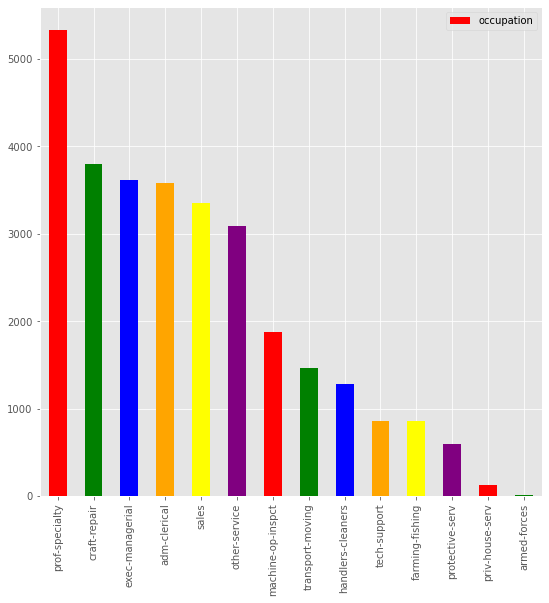

In [490]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["occupation"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **race**:

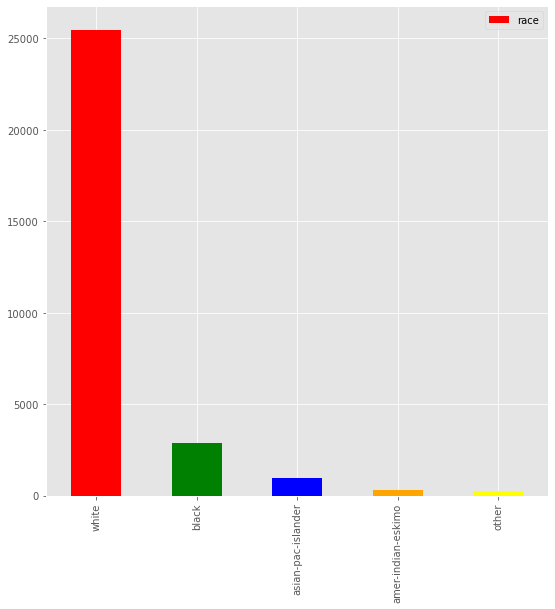

In [491]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["race"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **sex**:

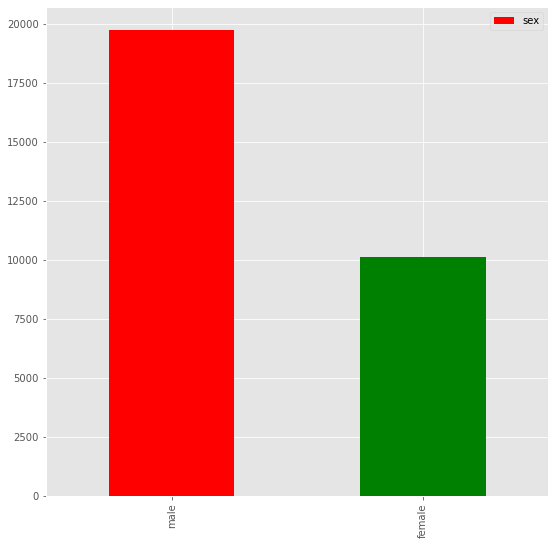

In [492]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["sex"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **relationship**:

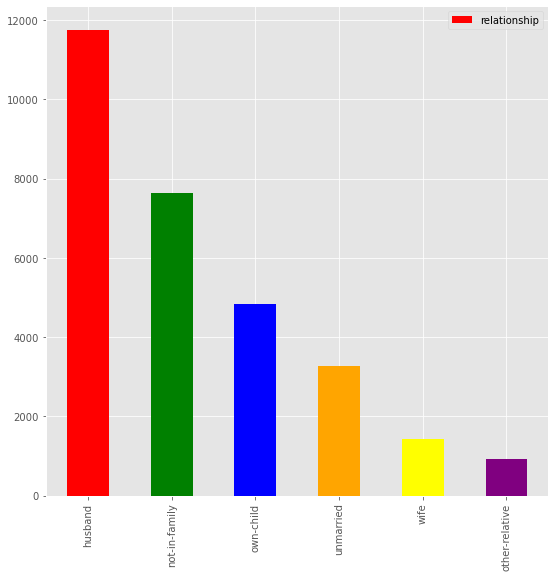

In [493]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["relationship"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **native_country**:

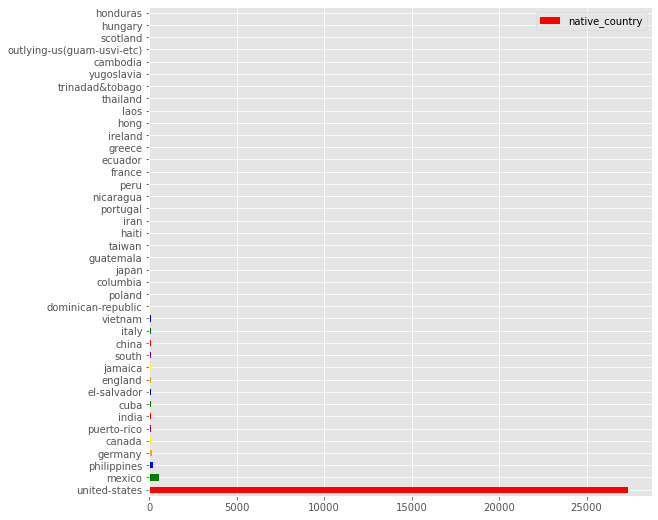

In [494]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["native_country"].value_counts().plot.barh(color = colors, legend = True);
plt.legend();

Value_counts for **income**:

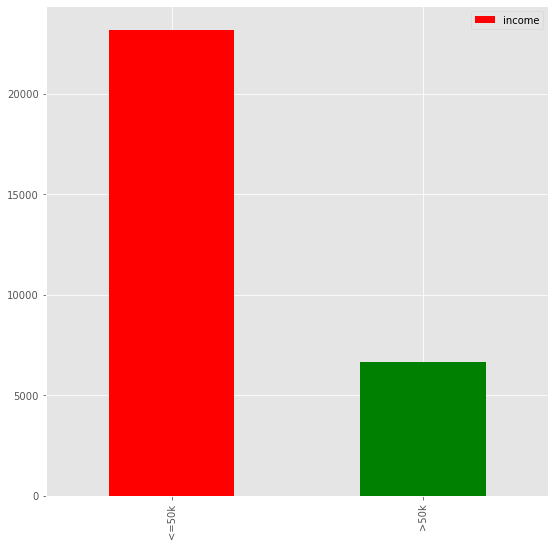

In [495]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["income"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

In [496]:
df["income"].value_counts() * 100 / len(df)

<=50k    77.692101
>50k     22.307899
Name: income, dtype: float64

#### 3.2) GroupBy

In [497]:
df.head()

,age,workclass,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,62,local-gov,159908,bachelors,13,married-civ-spouse,adm-clerical,wife,white,female,0,1258,38,united-states,<=50k
1,72,local-gov,144515,doctorate,16,married-civ-spouse,exec-managerial,husband,white,male,0,1258,40,united-states,<=50k
2,76,private,224680,prof-school,15,married-civ-spouse,prof-specialty,husband,white,male,0,1258,20,united-states,<=50k
3,66,private,350498,some-college,10,married-civ-spouse,transport-moving,husband,white,male,0,1258,20,united-states,<=50k
4,33,local-gov,262042,hs-grad,9,divorced,adm-clerical,own-child,white,female,0,1138,40,united-states,<=50k


Calculate the mean of years for each profession and count:

In [498]:
mean_age = df.groupby("workclass")["age"].agg(["count", "mean"])
mean_age

,count,mean
workclass,,
federal-gov,885,42.550282
local-gov,1915,41.497128
never-worked,7,20.571429
private,22639,36.711869
self-emp-inc,938,45.535181
self-emp-not-inc,2213,44.460009
state-gov,1217,39.106820
without-pay,14,47.785714


In [499]:
mean_age["count"] * 100 / mean_age["count"].sum()

workclass
federal-gov          2.967011
local-gov            6.420142
never-worked         0.023468
private             75.898485
self-emp-inc         3.144696
self-emp-not-inc     7.419203
state-gov            4.080059
without-pay          0.046936
Name: count, dtype: float64

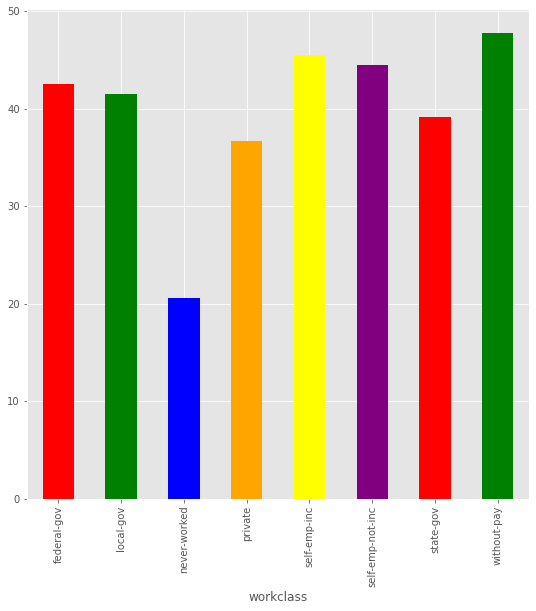

In [500]:
mean_age["mean"].plot.bar(color = colors);

As we can see from our data, the average age for private is 36 years. At the same time, the average age for those who have never worked is 20-21, which is not surprising - since students usually start working from the age of 22. We can also see that 14 people (0.04%) do not receive a salary.

Let's see how education is distributed depending on the sex of a person

In [501]:
education_sex = df.groupby(["education", "sex"])["sex"].count()
education_sex

education     sex   
10th          female     274
              male       594
11th          female     422
              male       698
12th          female     139
              male       272
5th-6th       female      81
              male       229
7th-8th       female     150
              male       440
9th           female     136
              male       355
assoc-acdm    female     392
              male       595
assoc-voc     female     474
              male       822
bachelors     female    1519
              male      3337
doctorate     female      64
              male       265
hs-grad       female    3228
              male      6579
masters       female     473
              male      1022
prof-school   female      79
              male       353
some-college  female    2682
              male      4154
Name: sex, dtype: int64

In [502]:
education_sex * 100 / education_sex.sum()

education     sex   
10th          female     0.918600
              male       1.991417
11th          female     1.414778
              male       2.340083
12th          female     0.466005
              male       0.911895
5th-6th       female     0.271557
              male       0.767735
7th-8th       female     0.502883
              male       1.475124
9th           female     0.455947
              male       1.190157
assoc-acdm    female     1.314201
              male       1.994770
assoc-voc     female     1.589111
              male       2.755800
bachelors     female     5.092531
              male      11.187475
doctorate     female     0.214563
              male       0.888427
hs-grad       female    10.822046
              male      22.056457
masters       female     1.585758
              male       3.426311
prof-school   female     0.264852
              male       1.183452
some-college  female     8.991552
              male      13.926512
Name: sex, dtype: float64

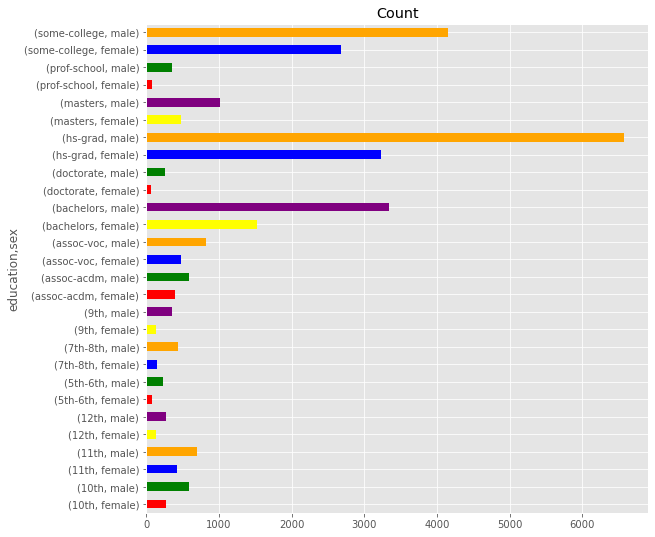

In [503]:
education_sex.plot.barh(color = colors);
plt.title("Count");

Mean age by sex and education:

In [504]:
df.groupby(["education", "sex"])["age"].mean()

education     sex   
10th          female    35.226277
              male      37.971380
11th          female    30.781991
              male      33.064470
12th          female    29.690647
              male      32.970588
5th-6th       female    44.135802
              male      41.882096
7th-8th       female    49.080000
              male      47.411364
9th           female    41.250000
              male      40.738028
assoc-acdm    female    36.257653
              male      37.680672
assoc-voc     female    37.466245
              male      38.813869
bachelors     female    35.367347
              male      39.953551
doctorate     female    45.500000
              male      47.860377
hs-grad       female    38.474287
              male      38.806050
masters       female    42.623679
              male      44.125245
prof-school   female    40.139241
              male      44.909348
some-college  female    33.546234
              male      36.646124
Name: age, dtype: float64

Text(0.5, 1.0, 'Mean age')

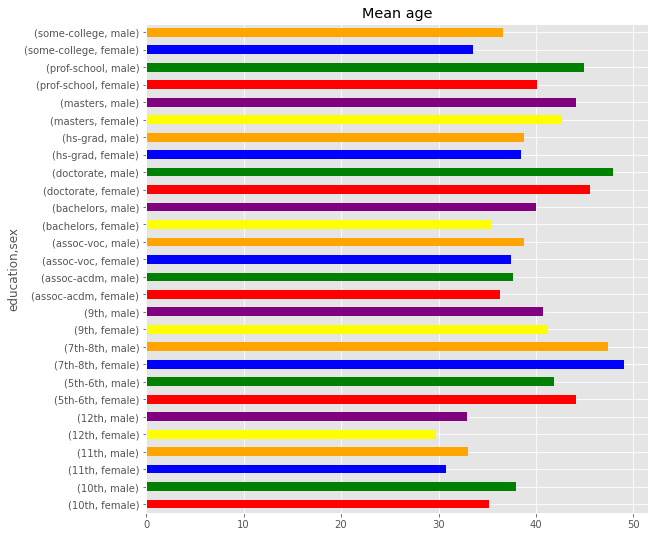

In [505]:
df.groupby(["education", "sex"])["age"].mean().plot.barh(color = colors);
plt.title("Mean age")

#### 3.3) Statistical modelling (Nominative data, Non-parametric ANOVA)

Let's see how the profitability is interrelated depending on the:
1. **Sex**
2. **Race**
3. **Relationship**

We will use next statistical methods:
1. **Chisquare test**
2. **Fisher's exact test**
3. **Conjugacy coefficients (Phi, Association, Pearson, Cramer, Chuprov)**

In [506]:
def contingency2x2_coefficients(data, return_coefficients = False):
    
    if isinstance(data, pd.core.frame.DataFrame):
        data = data.to_numpy()
        
    K_a = (data[0, 0] * data[1, 1] - data[0, 1] * data[1, 0]) / (data[0, 0] * data[1, 1] + data[0, 1] * data[1, 0])
    K_k = (data[0, 0] * data[1, 1] - data[0, 1] * data[1, 0]) / ((data[0, 0] + data[0, 1]) * (data[0, 1] + data[1, 1]) * (data[0, 0] + data[1, 0]) * (data[1, 0] + data[1, 1])) ** (0.5)
    
    print("The coefficient of association: ", K_a)
    print("The coefficient of contingency: ", K_k)
    
    if (K_a >= 0.5) or (K_k >= 0.3):
        print("The relationship is quite strong between the two features")
    else:
        print("The relationship is weak between the two features")
        
    if return_coefficients:
        return (K_a, K_k)

In [507]:
def plot_chi2_test(data, yets_correction = True, return_statistics = False, only_coefficients = False, fisher_test = True):
    
    if isinstance(data, pd.core.frame.DataFrame):
        data = data.to_numpy()
    
    chi2, p, dof, ex = stats.chi2_contingency(data, correction = yets_correction)
    margins_sum = stats.contingency.margins(data)
    summed = margins_sum[0].sum()
    
    if not only_coefficients:
        chi2_critical = stats.chi2.ppf(0.95, df = (data.shape[0] - 1) * (data.shape[1] - 1))
        
        chi2_arange = np.arange(0, chi2_critical + 2, 0.01)
        chi2_vals = stats.chi2.pdf(chi2_arange, df = (data.shape[0] - 1) * (data.shape[1] - 1))
        
        plt.plot(chi2_arange, chi2_vals, label = "Chisquare distribution", color = "k")
        plt.axvline(chi2, color = "b", label = "Chisquare-statistical")
        plt.axvline(chi2_critical, color = "r", label = "Chisquare-critical", linestyle = "dashed")
        plt.ylim(0, chi2_vals[1:].max())
        
        plt.fill_between(np.arange(chi2, chi2_critical + 2, 0.01), stats.chi2.pdf(np.arange(chi2, chi2_critical + 2, 0.01), df = (data.shape[0] - 1) * (data.shape[1] - 1)), color = "dodgerblue")
        
        if p <= 0.05:
            print("The features are interrelated. P-value: {}".format(p))
        else:
            print("The features are not interrelated. P-value: {}".format(p))
            
        if ((data.shape[0] == 2) and (data.shape[1] == 2)) and fisher_test:
            oddsratio, p_fisher = stats.fisher_exact(data)
            
            print("Fisher's test p-value: ", p_fisher)
            
        print("Chisquare statistics: ", chi2)
        print("Chisquare critical ", chi2_critical)
        print("-"*10)
    
    Pirson_coefficient = (chi2  / (chi2 + summed)) ** (0.5)
    Chuprov_coefficient = (chi2 / (summed * ((data.shape[0] - 1) * (data.shape[1] - 1)) ** (0.5)))
    
    if (data.shape[0] == 2) and (data.shape[1] == 2):
        phi_coefficient = (chi2 / summed) ** (0.5)
        print("Phi coefficient: ", phi_coefficient)
    else:
        Cramer_coefficient = ((chi2 / summed) / (np.min([data.shape[0] - 1, data.shape[1] - 1]))) ** (0.5)
        print("Cramer's coefficient: ", Cramer_coefficient)
    

    
    print("Pearson's coefficient: ", Pirson_coefficient)
    print("Chuprov's coefficient: ", Chuprov_coefficient)

In [508]:
sex_income = pd.crosstab(index = df["sex"], columns = df["income"])
sex_income

income,<=50k,>50k
sex,,
female,9091,1022
male,14083,5632


In [509]:
contingency2x2_coefficients(sex_income)

The coefficient of association:  0.5611497618858793
The coefficient of contingency:  0.209922128616096
The relationship is quite strong between the two features


The features are interrelated. P-value: 8.22896194288344e-288
Fisher's test p-value:  6.695746e-318
Chisquare statistics:  1314.4394268671558
Chisquare critical  3.841458820694124
----------
Phi coefficient:  0.209922128616096
Pearson's coefficient:  0.20544424233891723
Chuprov's coefficient:  0.04406730008271275


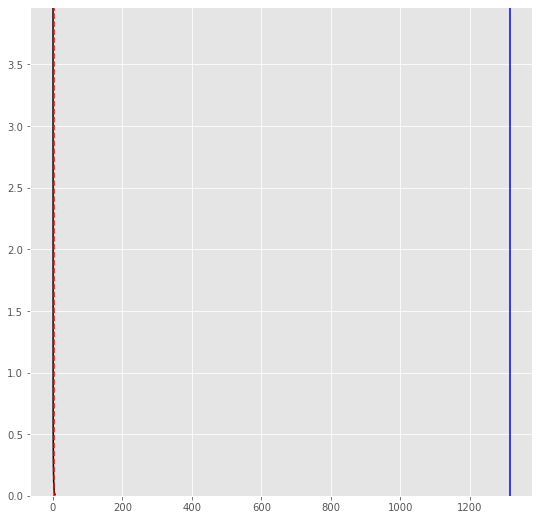

In [510]:
plot_chi2_test(sex_income, yets_correction = False)

The relationship between gender and salary is very **high**. Let's look at the race column:

In [511]:
race_income = pd.crosstab(index = df["race"], columns = df["income"])
race_income

income,<=50k,>50k
race,,
amer-indian-eskimo,263,32
asian-pac-islander,712,230
black,2555,316
other,225,22
white,19419,6054


The features are interrelated. P-value: 3.1775138046990016e-62
Chisquare statistics:  293.1973472457482
Chisquare critical  9.487729036781154
----------
Cramer's coefficient:  0.099144345723368
Pearson's coefficient:  0.09866063414132854
Chuprov's coefficient:  0.0049148006444573586


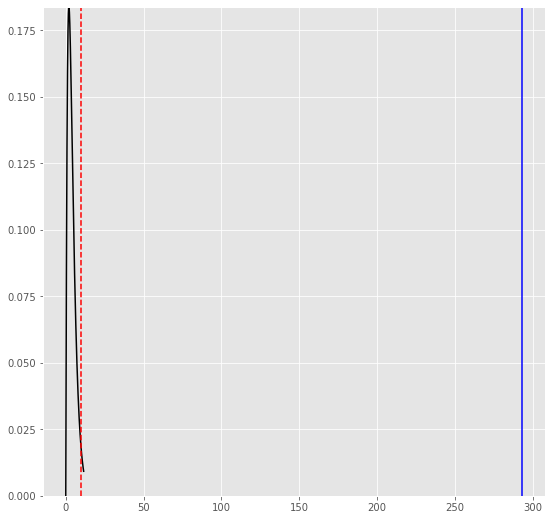

In [512]:
plot_chi2_test(race_income)

Here, too, we see a high correlation between race and wage levels. 

In [513]:
relationship_income = pd.crosstab(index = df["relationship"], columns = df["income"])
relationship_income

income,<=50k,>50k
relationship,,
husband,6739,5022
not-in-family,6925,711
other-relative,883,30
own-child,4768,58
unmarried,3090,181
wife,769,652


The features are interrelated. P-value: 0.0
Chisquare statistics:  5983.957656123724
Chisquare critical  11.070497693516351
----------
Cramer's coefficient:  0.4479011614780545
Pearson's coefficient:  0.4087711385680971
Chuprov's coefficient:  0.0897179569101043


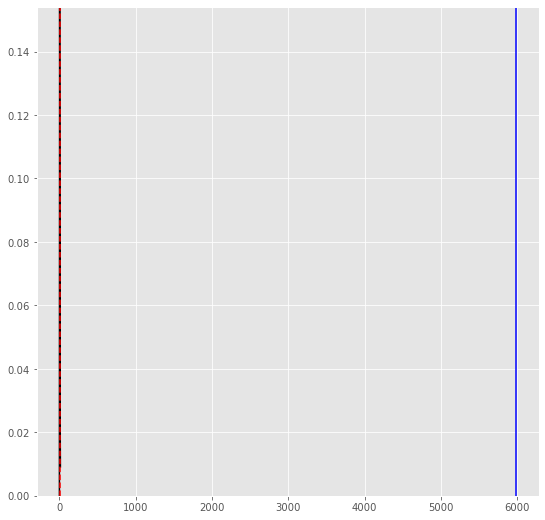

In [514]:
plot_chi2_test(relationship_income)

And here we can observe a strong relationship. It turns out that the profitability of a person depends on his gender, race and relationship.

Let's see if the profitability depends on the age. To do this, we will use the **Student's t-criterion**

In [515]:
df.replace({"<=50k": 0, ">50k": 1}, inplace = True)

In [516]:
income_greater50 = df["age"][df["income"] ==  0]
income_lesseq50 = df["age"][df["income"] == 1]

In [517]:
len(income_greater50), len(income_lesseq50)

(23174, 6654)

We can apply the Student's criterion if:
1. The values being compared do not constitute a pair of correlating values
2. The distribution of features in each sample corresponds to the normal distribution
3. The variances of the feature in the samples are approximately equal

First, we will check the third condition using the **Levene test**:

In [518]:
statistics, p_value = stats.levene(income_greater50, income_lesseq50)

if p_value < 0.05:
    print("The variances are not equal. P-value: {}".format(p_value))
else:
    print("The variances are equal. P-value: {}".format(p_value))

The variances are not equal. P-value: 1.2101724570979645e-132


Second condition:

In [519]:
def plot_histogram_and_qq(data, column_name = "Hisogram", distribution_type="norm", normal_tests = True):
    
    mu = np.mean(data)
    sigma = np.std(data)
    
    # Plot histogram of the 1000 points
    plt.figure(figsize=(12,6))
    ax = plt.subplot(1,2,1)
    count, bins, ignored = plt.hist(data, 30, density=True)
    ax.set_title(column_name)
    ax.set_xlabel('Values')
    ax.set_ylabel('Freq')

    # Overlay the bell curve (normal distribution) on the bins data
    bell_curve = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))
    plt.plot(bins, bell_curve, linewidth=2, color='r')

    # Q-Q plot
    plt.subplot(1,2,2)
    res = stats.probplot(data, dist=distribution_type, plot=plt)
    # (osm, osr) = res[0]
    # (slope, intercept, r) = res[1]
    # For details see: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html
    # print("slope, intercept, r:", slope, intercept, r)
    # print("r is the square root of the coefficient of determination")

    plt.show()
    
    print("-"*50)
    print("Min/Max: ", [np.min(data), np.max(data)])
    print("The three sigma rule: ", [mu - 3 * sigma, mu + 3 * sigma])
    print("Mean/Mode/Median: ", [np.mean(data), stats.mode(data), np.median(data)])
    print("Skewness/Kurtosis: ", [stats.skew(data), stats.kurtosis(data)])
    
    if normal_tests and distribution_type == "norm":
        print("-"*50)
        
        statistics, p = stats.normaltest(data)
        
        if p < 0.05:
            print("D'Agostino test: the sample is not taken from a normal distribution! P-value: {}".format(p))
        else:
            print("D'Agostino test: the sample is taken from a normal distribution. P-value: {}".format(p))
            
        if data.shape[0] > 2000:
            statistics, p = stats.jarque_bera(data)
            
            if p < 0.05:
                print("Jarque-Bera test: the sample is not taken from a normal distribution! P-value: {}".format(p))
            else:
                print("Jarque-Bera test: the sample is taken from a normal distribution. P-value: {}".format(p))
        else:
            statistics, p = stats.shapiro(data)
            
            if p < 0.05:
                 print("Shapiro test: the sample is not taken from a normal distribution! P-value: {}".format(p))
            else:
                print("Shapiro test: the sample is taken from a normal distribution. P-value: {}".format(p))

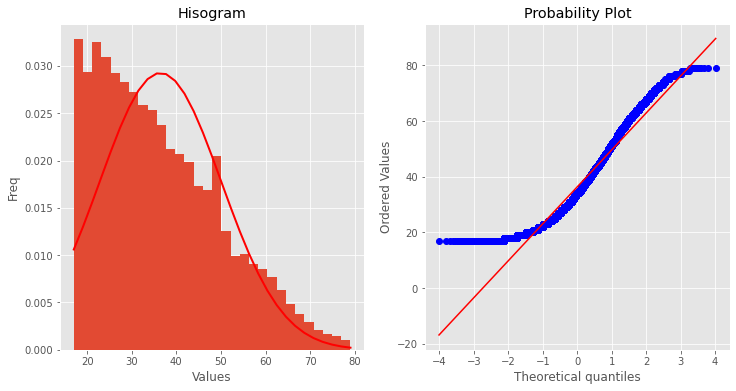

--------------------------------------------------
Min/Max:  [17, 79]
The three sigma rule:  [-4.476598818175219, 77.33756369260345]
Mean/Mode/Median:  [36.43048243721412, ModeResult(mode=array([23]), count=array([825])), 34.0]
Skewness/Kurtosis:  [0.686558744968736, -0.2684932398933011]
--------------------------------------------------
D'Agostino test: the sample is not taken from a normal distribution! P-value: 0.0
Jarque-Bera test: the sample is not taken from a normal distribution! P-value: 0.0


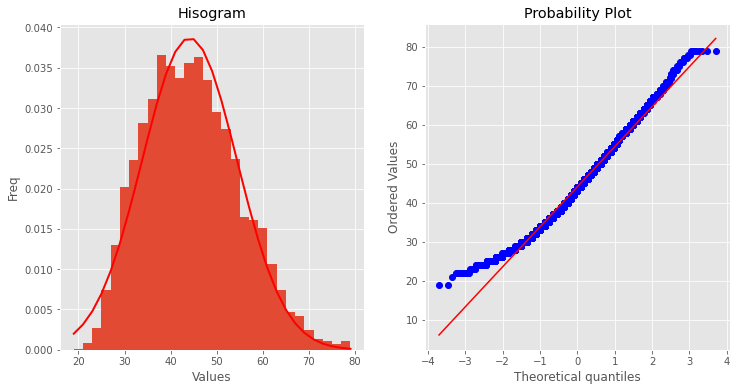

--------------------------------------------------
Min/Max:  [19, 79]
The three sigma rule:  [13.163989745365676, 75.05723057323968]
Mean/Mode/Median:  [44.110610159302674, ModeResult(mode=array([47]), count=array([249])), 44.0]
Skewness/Kurtosis:  [0.37593426232435756, -0.23013931969906398]
--------------------------------------------------
D'Agostino test: the sample is not taken from a normal distribution! P-value: 1.0831897221527115e-36
Jarque-Bera test: the sample is not taken from a normal distribution! P-value: 0.0


In [520]:
plot_histogram_and_qq(income_greater50)
plot_histogram_and_qq(income_lesseq50)

The variances are not equal and the samples are not taken from a normal distribution. We can't use the Student's criterion. We can try to use a nonparametric analog for one-factor analysis of variance - **the Kruskell Wallis H-test**:

In [521]:
stats.kruskal(income_greater50, income_lesseq50)

KruskalResult(statistic=2217.6615682639413, pvalue=0.0)

The criterion tells us that the median ages for each of the groups are not equal, so we can conclude that the profitability depends on the age.

### 4) Feature Engineering

There are categorical features in our data that machine learning models cannot understand due to their non-numeric nature. Let's use **OneHot encoding**

In [522]:
from sklearn.preprocessing import OneHotEncoder

In [523]:
categorical_cols = df.select_dtypes(exclude = [np.number]).columns

In [524]:
onehotencoder = OneHotEncoder()
encoding_data = pd.DataFrame(onehotencoder.fit_transform(df[categorical_cols]).toarray(), 
                             columns = onehotencoder.get_feature_names(categorical_cols))
encoding_data

,workclass_federal-gov,workclass_local-gov,workclass_never-worked,workclass_private,workclass_self-emp-inc,workclass_self-emp-not-inc,workclass_state-gov,workclass_without-pay,education_10th,education_11th,...,native_country_portugal,native_country_puerto-rico,native_country_scotland,native_country_south,native_country_taiwan,native_country_thailand,native_country_trinadad&tobago,native_country_united-states,native_country_vietnam,native_country_yugoslavia
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29823,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29824,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29825,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29826,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Let's select the most informative numeric features:

In [525]:
df_float = df.select_dtypes(include = [np.number])

In [526]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [527]:
X = df_float.iloc[:, :-1].copy()
y = df_float["income"].copy()

min_features = 3
estimator = LogisticRegression()
rfecv = RFECV(estimator = estimator, step = 1, cv = 5,
             scoring = "roc_auc", min_features_to_select = min_features)

rfecv.fit(X, y)
print("Optimal number of features: ", rfecv.n_features_)
print("Number of all features: ", len(X.columns))

Optimal number of features:  4
Number of all features:  6


Plot results:

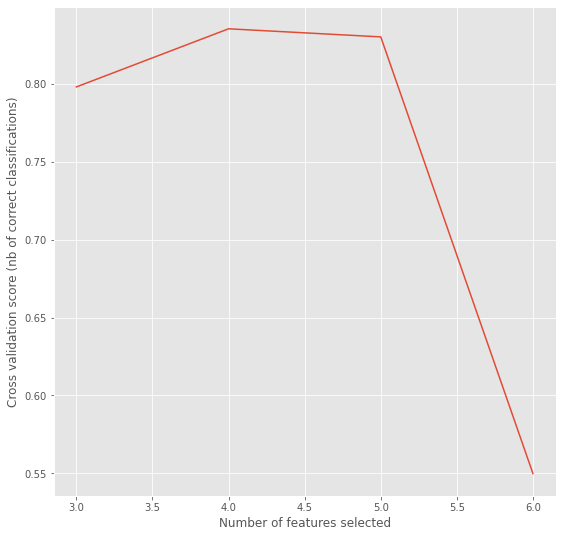

In [528]:
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features,
               len(rfecv.grid_scores_) + min_features),
         rfecv.grid_scores_);

Getting names of best features:

In [531]:
for i, column in enumerate(X.columns):
    print(f'Column: {i}, {column}, Selected {rfecv.support_[i]}, Rank: {rfecv.ranking_[i]}')

Column: 0, age, Selected True, Rank: 1
Column: 1, final_weight, Selected False, Rank: 3
Column: 2, education_num, Selected True, Rank: 1
Column: 3, capital_gain, Selected False, Rank: 2
Column: 4, capital_loss, Selected True, Rank: 1
Column: 5, hours_per_week, Selected True, Rank: 1


Next best features:
1. age
2. education_num
3. capital_loss
4. hours_per_week

We will not take into account the "education_num" column, because we have encoded string values in the same column - "education".

Let's combine our features:

In [532]:
X = pd.concat([encoding_data, df[["age", "capital_loss", "hours_per_week"]]], axis = 1)
y = df["income"].copy()

,workclass_federal-gov,workclass_local-gov,workclass_never-worked,workclass_private,workclass_self-emp-inc,workclass_self-emp-not-inc,workclass_state-gov,workclass_without-pay,education_10th,education_11th,...,native_country_south,native_country_taiwan,native_country_thailand,native_country_trinadad&tobago,native_country_united-states,native_country_vietnam,native_country_yugoslavia,age,capital_loss,hours_per_week
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,62,1258,38
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,72,1258,40
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76,1258,20
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66,1258,20
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33,1138,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29823,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,22,0,40
29824,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27,0,38
29825,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40,0,40
29826,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,58,0,40
